# Image Classification with PyTorch

## Implementation

### Imports

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

### Load Data

In [20]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4
target_classes = [0, 2]

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
filtered_train_indices = [i for i, label in enumerate(trainset.targets) if label in target_classes]
filtered_trainset = Subset(trainset, filtered_train_indices)

final_trainset = torch.utils.data.DataLoader(filtered_trainset, batch_size=batch_size, shuffle=True, num_workers=2)




testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)                                     
filtered_test_indices = [i for i, label in enumerate(testset.targets) if label in target_classes]
filtered_test_set = Subset(testset, filtered_test_indices)

final_testset = torch.utils.data.DataLoader(filtered_test_set, batch_size=batch_size, shuffle=True, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Show Images From Imported Data

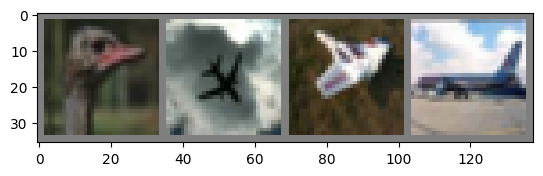

bird  plane plane plane


In [22]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(final_trainset)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Define the (Convolutional) Neural Network

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch; from 3D tensor to 1D tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

Explanation:
We have the first convolution layer that takes in three input channels for RGB and 6 output channels, which are basically the number of filters/kernels. Moreover, it takes the size of each filters as its third argument. In this case, we aork with 5x5 filters. MaxPool2d is a down-sampling technique, which is commonly used after convolutional layers to decude spatial dimensions (?) ==> reducing the number of parameters in the network. The linear layers are fully connected layers that takes the number of inputs and outputs as additional parameters. As an activation function, we use ReLu.

### Defining the Loss function and the optimizer to update weights

In [26]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # CrossEntropyLoss as the Loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # SGD as the optimizer; for all types of optimizers, see https://pytorch.org/docs/stable/optim.html

### Train the network

In [28]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(final_trainset, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.606
[2,  2000] loss: 0.406
Finished Training


Now we need to save our model to test it on the test data:

In [29]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Test the network on the test data

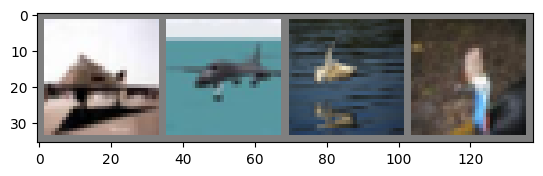

GroundTruth:  plane plane bird  bird 


In [32]:
dataiter = iter(final_testset)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [33]:
# We don't need to load the model; just showing how it works
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [34]:
outputs = net(images)

In [35]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  plane plane bird  bird 


#### Performance on the whole dataset

In [37]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs, so we don't need the gradients
with torch.no_grad():
    for data in final_trainset:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 83 %
